### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from acquire import acquire_data
from prepare import the_master_imputer, data_prep, percent_of_values_missing, change_data_to_int, change_data_to_object, zillow_single_unit_prop
from set_counties import create_county_cols
from summerize import summarize_data, show_distribution
from preprocessing import split_my_data, scale_data

# Acquire

- using our function from our acquire.py file to import our data from SQL and import it into a csv, drop the Unnamed column and assign it to a data frame
- in our SQL query we decided to eliminate all properties that were not a single unit family residential home
- we also cut some of our outliers by removing any home where their structuretaxvaluedollarcnt was > $1,000,000

In [2]:
df = acquire_data()

Acquiring data ...

- csv already exist

Data has been acquired


# Prepare

**more outlier control**

- this function below, limits our result's to include homes where the unit's square footage is no less than 500 sq ft, and no less than 1 bedroom and 1 bathroom 

In [3]:
df = zillow_single_unit_prop(df)

- our data_prep function removes any column missing 50% or more of their data as well as any row missing up to 75% of it's data (*We didn't want to waste time strategizing ways to accuratly sum up data missing over 50% of it's values*) 

In [4]:
df = data_prep(df)

- the function below tells us what percent of each column is missing

In [5]:
percent_of_values_missing(df)

parcelid                        0.00
logerror                        0.00
transactiondate                 0.00
bathroomcnt                     0.00
bedroomcnt                      0.00
calculatedfinishedsquarefeet    0.00
fips                            0.00
latitude                        0.00
longitude                       0.00
lotsizesquarefeet               0.62
regionidcity                    1.96
regionidcounty                  0.00
regionidzip                     0.04
yearbuilt                       0.06
structuretaxvaluedollarcnt      0.00
taxvaluedollarcnt               0.00
landtaxvaluedollarcnt           0.00
taxamount                       0.01
dtype: float64

- using the_master_imputer function, we will fill all of our missing functions with the median value, for that column's rows (*Since we weren't missing more than 2% of any data, we felt that the median would suffice for the missing values in our dataset*)

In [6]:
df = the_master_imputer(df)

We see that all of our missing values are taken care of

In [7]:
df.isna().sum()

parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
dtype: int64

>now we're going to take our fips # and use that to impute what county our observations were made in using our create_county_cols function and in the process we're going to drop our fips & our regioncounty columns.
fips source: [THIS LINK](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697)

In [8]:
df = create_county_cols(df)

### Lets change our values so we can have less noise in our exploration / modeling phase

- using our change_data_to_object function to change the datatypes of *parcelid*, *regionidcity*, *regionidcounty*, *fips* & *regionidzip* to object. (we dont want to do any addition with our unit id's)

In [9]:
cols = ['parcelid', 'regionidzip', 'regionidcity', 'LA', 'Ventura', 'Orange', 'fips', 'regionidcounty']
df = change_data_to_object(df, cols)

- using our change_data_to_int function to change the datatypes of *yearbuilt*, *latitude*, *longitude*, *lotsizesquarefeet*, *calculatedfinishedsquarefeet*, & *bedroomcnt* to change these datatypes from float's to integers to make the data more exclusive

In [10]:
cols = ['yearbuilt', 'latitude', 'longitude', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'bedroomcnt' ]
df = change_data_to_int(df, cols)

### We're going summarize what our data looks like
- this functions runs a .info, a .describe and a .shape on our data and returns it in a pandas series

In [11]:
summarize_data(df)

******** Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51377 entries, 0 to 51585
Data columns (total 22 columns):
logerror                        51377 non-null float64
transactiondate                 51377 non-null object
bathroomcnt                     51377 non-null float64
structuretaxvaluedollarcnt      51377 non-null float64
taxvaluedollarcnt               51377 non-null float64
landtaxvaluedollarcnt           51377 non-null float64
taxamount                       51377 non-null float64
county                          51377 non-null object
parcelid                        51377 non-null object
regionidzip                     51377 non-null object
regionidcity                    51377 non-null object
LA                              51377 non-null object
Ventura                         51377 non-null object
Orange                          51377 non-null object
fips                            51377 non-null object
regionidcounty                  51377 non-null object
yearbui

In [12]:
df.describe()

,logerror,bathroomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,yearbuilt,latitude,longitude,lotsizesquarefeet,calculatedfinishedsquarefeet,bedroomcnt
count,51377.000000,51377.000000,51377.000000,5.137700e+04,5.137700e+04,51377.000000,51377.000000,5.137700e+04,5.137700e+04,5.137700e+04,51377.000000,51377.000000
mean,0.017715,2.261547,175356.551725,4.754713e+05,3.001148e+05,5822.438304,1963.138836,3.402375e+07,-1.181927e+08,1.095165e+04,1870.114818,3.291882
std,0.173323,0.931872,151204.249558,4.589476e+05,3.585572e+05,5285.886480,22.856909,2.746125e+05,3.562389e+05,8.689483e+04,853.040433,0.909385
min,-4.655420,1.000000,148.000000,3.254000e+03,1.610000e+02,49.180000,1878.000000,3.334062e+07,-1.194754e+08,2.360000e+02,501.000000,1.000000
25%,-0.024559,2.000000,76539.000000,1.914510e+05,7.383600e+04,2631.590000,1950.000000,3.382712e+07,-1.183974e+08,5.578000e+03,1264.000000,3.000000
50%,0.006746,2.000000,130013.000000,3.683750e+05,2.136120e+05,4588.505000,1960.000000,3.402162e+07,-1.181506e+08,6.800000e+03,1648.000000,3.000000
75%,0.039774,3.000000,219715.000000,6.010000e+05,3.970250e+05,7183.460000,1978.000000,3.418916e+07,-1.179296e+08,8.636000e+03,2271.000000,4.000000
max,5.262999,10.000000,999140.000000,1.087391e+07,1.054104e+07,129365.370000,2016.000000,3.481877e+07,-1.175546e+08,6.971010e+06,7970.000000,11.000000


## Preprocessing

- using split_my_data function to split our data into train, test and validate data frames

In [13]:
train, test, val = split_my_data(df, .15, .50)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43670 entries, 230 to 49888
Data columns (total 22 columns):
logerror                        43670 non-null float64
transactiondate                 43670 non-null object
bathroomcnt                     43670 non-null float64
structuretaxvaluedollarcnt      43670 non-null float64
taxvaluedollarcnt               43670 non-null float64
landtaxvaluedollarcnt           43670 non-null float64
taxamount                       43670 non-null float64
county                          43670 non-null object
parcelid                        43670 non-null object
regionidzip                     43670 non-null object
regionidcity                    43670 non-null object
LA                              43670 non-null object
Ventura                         43670 non-null object
Orange                          43670 non-null object
fips                            43670 non-null object
regionidcounty                  43670 non-null object
yearbuilt          

In [15]:
train_scaled = train[['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt']]
train_scaled, scaler = scale_data(train_scaled)
train[['scaled_structuretaxvaluedollarcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_bedroomcnt']] = train_scaled[['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt']]
    




# Exploration

- Perform clustering with logerror, longitude & latitude

In [16]:
X = train[['logerror', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

train['log_cluster'] = kmeans.predict(X)

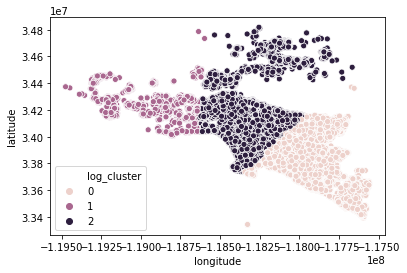

In [17]:
sns.scatterplot(x='longitude', y='latitude' , hue='log_cluster', data=train)

- 3 distinct clusters of areas found using longitude and latitude
- lets find out if they're correlated with our counties by visualizing our longitude, latitude and hue it by county

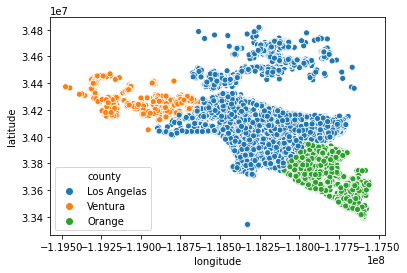

In [18]:
sns.scatterplot('longitude', 'latitude', hue='county', data=train)

- visually looks incredibly similar.
- tells us that their logerror algorithm is dependent on where a home is located 

In [19]:
train.head()

,logerror,transactiondate,bathroomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,county,parcelid,regionidzip,...,yearbuilt,latitude,longitude,lotsizesquarefeet,calculatedfinishedsquarefeet,bedroomcnt,scaled_structuretaxvaluedollarcnt,scaled_calculatedfinishedsquarefeet,scaled_bedroomcnt,log_cluster
230,0.090921,2017-01-03,2.0,101849.0,169738.0,67889.0,2082.42,Los Angelas,10783039,96364,...,1951,34181933,-118546459,7654,1128,3,0.101804,0.083947,0.2,2
37011,0.188178,2017-07-10,1.5,226335.0,452670.0,226335.0,4848.08,Ventura,17282217,96383,...,1962,34195133,-118860249,9892,1016,3,0.226415,0.068952,0.2,1
19770,0.044840,2017-04-26,2.0,151204.0,431859.0,280655.0,5083.76,Ventura,17260896,97116,...,1970,34276636,-118674584,6991,1891,4,0.151208,0.186103,0.3,1
50681,-0.040180,2017-09-13,2.5,458083.0,1053673.0,595590.0,12137.42,Orange,14200286,97079,...,1992,33888911,-117750130,13500,3464,4,0.458397,0.396706,0.3,0
37426,-0.060420,2017-07-12,2.0,138074.0,172592.0,34518.0,2966.29,Los Angelas,11312167,97318,...,1992,34673952,-118090367,7029,1569,3,0.138065,0.142991,0.2,2


In [20]:
X = train[['logerror','scaled_calculatedfinishedsquarefeet' ]]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

train['sqft_cluster'] = kmeans.predict(X)

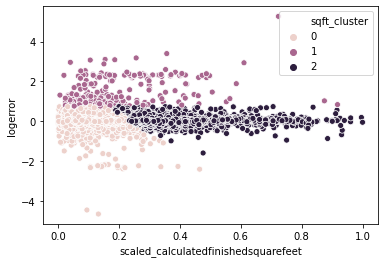

In [21]:
sns.scatterplot('scaled_calculatedfinishedsquarefeet', 'logerror', hue='sqft_cluster', data=train)

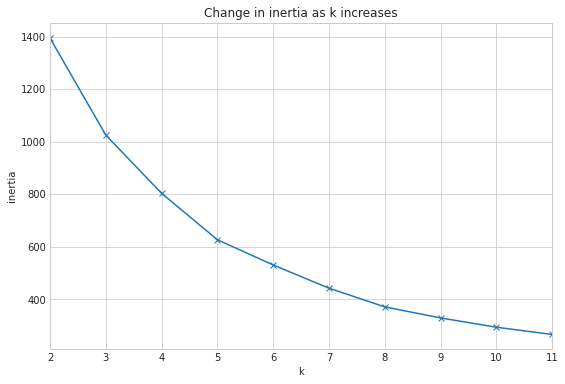

In [22]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- looks like the optimal k value would be about 5

In [23]:
X = train[['logerror', 'scaled_calculatedfinishedsquarefeet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

train['sqft_cluster'] = kmeans.predict(X)

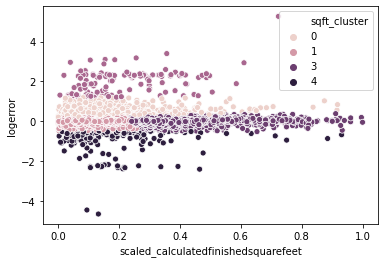

In [24]:
sns.scatterplot('scaled_calculatedfinishedsquarefeet', 'logerror', hue='sqft_cluster', data=train)

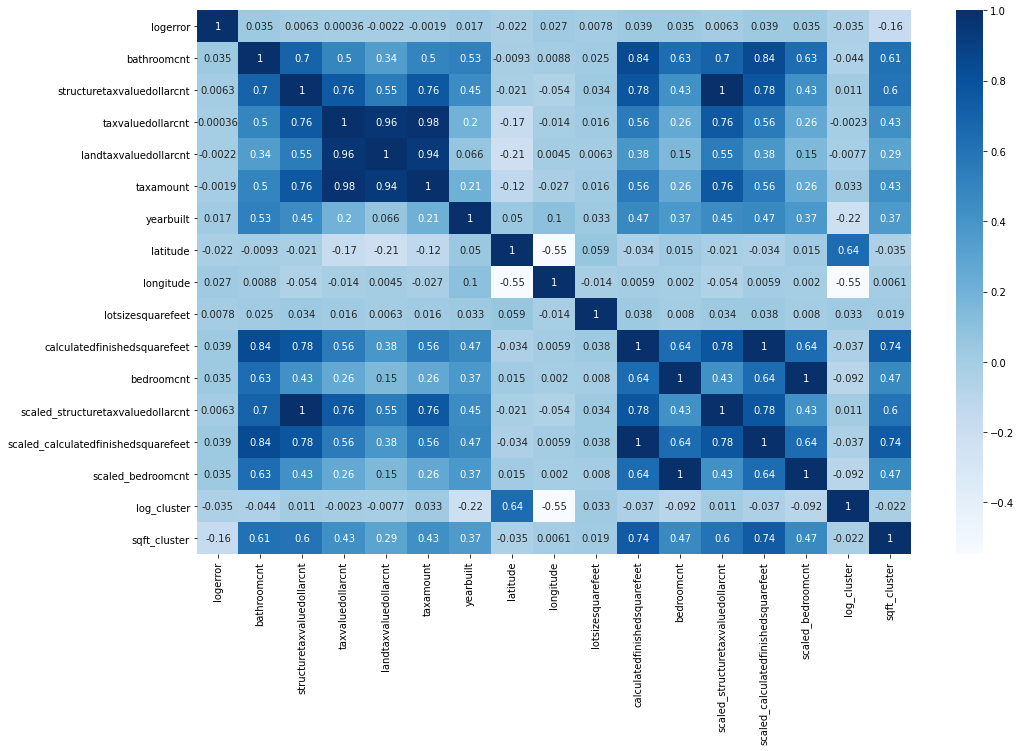

In [25]:
# Overall correlation of the features and the target.
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

In [27]:
X = train[['logerror', 'scaled_structuretaxvaluedollarcnt', 'scaled_bedroomcnt']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

train['bath_money_cluster'] = kmeans.predict(X)

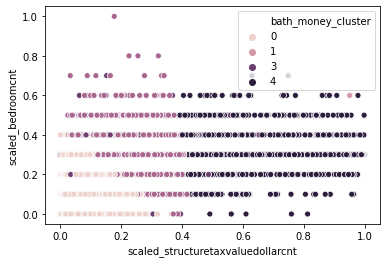

In [28]:
sns.scatterplot(x='scaled_structuretaxvaluedollarcnt', y='scaled_bedroomcnt', hue='bath_money_cluster', data=train)




# Modeling

- We used a *linear regression*, and *polynomial regression* algorithms to predict logerror

- The data used have been all of our features and specified clusters

#### step 1 encode the county column

In [29]:
# run this function
def encode(train, test, col_name):
    from sklearn.preprocessing import LabelEncoder
    
    # Integer Encoding
    int_encoder = LabelEncoder()
    train[col_name] = int_encoder.fit_transform(train[col_name])
    test[col_name] = int_encoder.transform(test[col_name])
    
    return train, test

In [30]:
train, val = encode(train, val, 'county')

#### step 2 split our train and validate data sets in X_train,and X_val's

In [32]:
x_train1 = train[['county','bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_train1 = train[['logerror']]

x_val = val[['county','bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_val = val[['logerror']]